<a href="https://colab.research.google.com/github/HenryJi529/ColabNotebooks/blob/main/LecturePytorch2.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
import torch
from sklearn.metrics import accuracy_score, recall_score

## Make Data

In [ ]:
from sklearn.datasets import make_circles 

In [ ]:
n_samples = 1000
X, y = make_circles(n_samples, noise=0.03, random_state=42) 
X.shape, y.shape

((1000, 2), (1000,))

In [ ]:
X[:5],y[:5]

(array([[ 0.75424625,  0.23148074],
        [-0.75615888,  0.15325888],
        [-0.81539193,  0.17328203],
        [-0.39373073,  0.69288277],
        [ 0.44220765, -0.89672343]]), array([1, 1, 1, 1, 0]))

In [ ]:
from pandas import DataFrame
df = DataFrame({
    "X1": X[:,0],
    "X2": X[:,1],
    "label": y    
})
df.head(10)

,X1,X2,label
0,0.754246,0.231481,1
1,-0.756159,0.153259,1
2,-0.815392,0.173282,1
3,-0.393731,0.692883,1
4,0.442208,-0.896723,0
5,-0.479646,0.676435,1
6,-0.013648,0.803349,1
7,0.771513,0.147760,1
8,-0.169322,-0.793456,1
9,-0.121486,1.021509,0


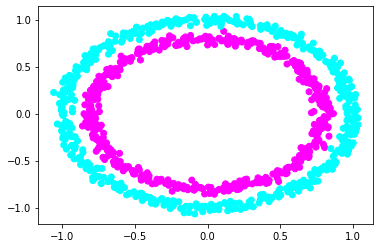

In [ ]:
import matplotlib.pyplot as plt
plt.scatter(X[:,0], X[:,1], c=y, cmap=plt.cm.cool)

In [ ]:
X = torch.from_numpy(X).type(torch.float)
y = torch.from_numpy(y).type(torch.float)

y = torch.unsqueeze(y, 1)

## Split Data

In [ ]:
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

In [ ]:
X_train.shape

torch.Size([800, 2])

## Build Model

In [ ]:
class CircleModel(torch.nn.Module):
  def __init__(self):
    super().__init__()
    self.layer1 = torch.nn.Linear(2,8, device="cuda")
    self.layer2 = torch.nn.Linear(8,4, device="cuda")
    self.layer3 = torch.nn.Linear(4,1, device="cuda")
    self.relu = torch.nn.ReLU()
  def forward(self, x:torch.Tensor) -> torch.Tensor:
    return self.layer3(
      self.relu(
        self.layer2(
          self.relu(
            self.layer1(x)
          )
        )
      )
    )

model = CircleModel()
model.parameters()
model.state_dict()

OrderedDict([('layer1.weight', tensor([[ 0.6568, -0.2387],
                      [-0.1133, -0.1604],
                      [-0.6009, -0.3518],
                      [-0.1896, -0.3498],
                      [-0.0078,  0.5196],
                      [-0.3565, -0.3884],
                      [-0.1198,  0.3490],
                      [ 0.5307,  0.4203]], device='cuda:0')),
             ('layer1.bias',
              tensor([ 0.2977,  0.1940,  0.2357,  0.2428, -0.1051, -0.6111, -0.1063, -0.1346],
                     device='cuda:0')),
             ('layer2.weight',
              tensor([[ 0.2758, -0.3054, -0.1116, -0.2606, -0.0085,  0.2144,  0.1010,  0.0618],
                      [ 0.1709,  0.0466, -0.2313, -0.1032,  0.0479,  0.2749,  0.1562,  0.0121],
                      [-0.3311, -0.0513,  0.0615, -0.3503, -0.0570, -0.0527, -0.2512,  0.2539],
                      [ 0.2181, -0.1007, -0.0117, -0.2321,  0.2072, -0.0091, -0.2462,  0.3308]],
                     device='cuda:0')),
       

In [ ]:
from collections import OrderedDict

model1 = torch.nn.Sequential(
    OrderedDict([
    ("layer1", torch.nn.Linear(2,4)),
    ("layer2", torch.nn.Linear(4,1))
    ])
).to("cuda")

model1.state_dict()

OrderedDict([('layer1.weight', tensor([[-0.4173, -0.6761],
                      [ 0.1813,  0.2515],
                      [ 0.1187,  0.6440],
                      [ 0.4650, -0.4958]], device='cuda:0')),
             ('layer1.bias',
              tensor([ 0.1049, -0.5062, -0.5743,  0.2922], device='cuda:0')),
             ('layer2.weight',
              tensor([[-0.4956, -0.0323,  0.0168,  0.3088]], device='cuda:0')),
             ('layer2.bias', tensor([-0.2010], device='cuda:0'))])

In [ ]:
with torch.inference_mode():
  y_pred = model(X_test.to("cuda"))

In [ ]:
lossFn = torch.nn.BCEWithLogitsLoss()
optimizer = torch.optim.Adam(params=model.parameters(), lr=0.01)

In [ ]:
epochs = 300

for epoch in range(epochs):
  model.train()

  y_logits = model(X_train.to("cuda"))
  y_pred_probs = torch.sigmoid(y_logits)
  y_pred = torch.round(y_pred_probs)
  loss = lossFn(y_logits, y_train.to("cuda"))
  acc = accuracy_score(y_train, y_pred.detach().cpu())

  optimizer.zero_grad()

  loss.backward()

  optimizer.step()

  model.eval()
  with torch.inference_mode():
    y_test_logits = model(X_test.to("cuda"))
    y_test_pred_probs = torch.sigmoid(y_test_logits)
    y_test_pred = torch.round(y_test_pred_probs)
    acc_test = accuracy_score(y_test_pred.to("cpu"), y_test.cpu())
    if epoch % 10 == 0:
      print(f"epoch {epoch}: acc: {acc}  acc_test: {acc_test}")

epoch 0: acc: 0.5275  acc_test: 0.605
epoch 10: acc: 0.52125  acc_test: 0.525
epoch 20: acc: 0.55  acc_test: 0.545
epoch 30: acc: 0.70375  acc_test: 0.705
epoch 40: acc: 0.5925  acc_test: 0.595
epoch 50: acc: 0.635  acc_test: 0.62
epoch 60: acc: 0.6775  acc_test: 0.65
epoch 70: acc: 0.725  acc_test: 0.72
epoch 80: acc: 0.79375  acc_test: 0.8
epoch 90: acc: 0.82875  acc_test: 0.805
epoch 100: acc: 0.84  acc_test: 0.825
epoch 110: acc: 0.90875  acc_test: 0.9
epoch 120: acc: 0.96375  acc_test: 0.94
epoch 130: acc: 0.99125  acc_test: 0.96
epoch 140: acc: 0.99875  acc_test: 0.985
epoch 150: acc: 1.0  acc_test: 0.99
epoch 160: acc: 0.99875  acc_test: 0.995
epoch 170: acc: 1.0  acc_test: 0.99
epoch 180: acc: 1.0  acc_test: 0.99
epoch 190: acc: 1.0  acc_test: 0.99
epoch 200: acc: 1.0  acc_test: 0.995
epoch 210: acc: 1.0  acc_test: 0.99
epoch 220: acc: 1.0  acc_test: 0.995
epoch 230: acc: 1.0  acc_test: 0.995
epoch 240: acc: 1.0  acc_test: 0.995
epoch 250: acc: 1.0  acc_test: 0.995
epoch 260: a

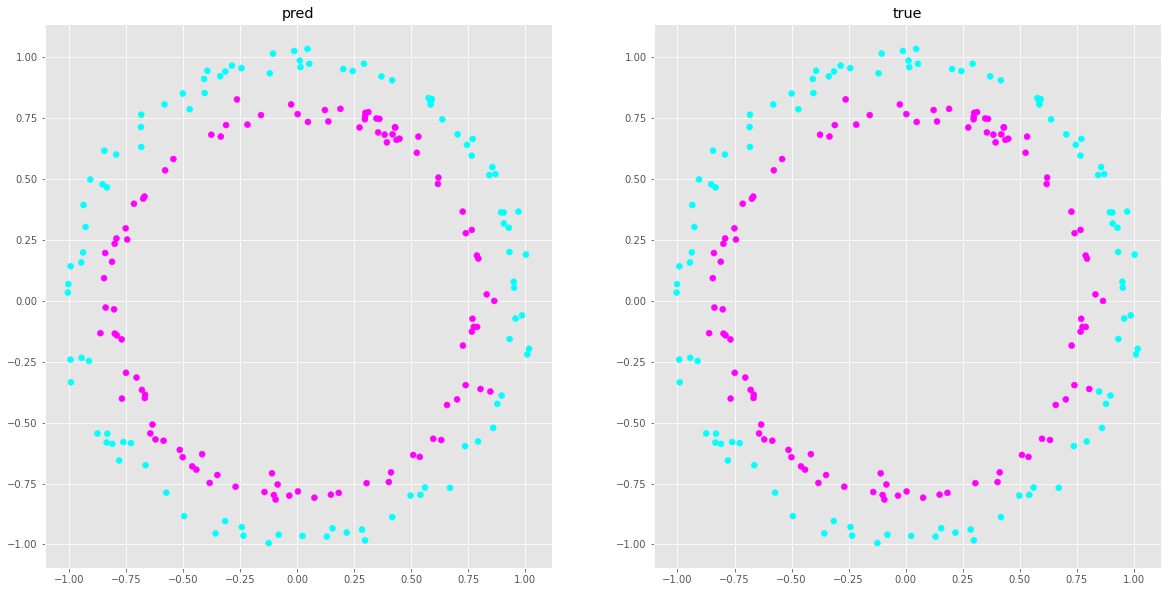

In [ ]:
with torch.inference_mode():
    y_test_logits = model(X_test.to("cuda"))
    y_test_pred_probs = torch.sigmoid(y_test_logits)
    y_test_pred = torch.round(y_test_pred_probs)
    acc_test = accuracy_score(y_test_pred.to("cpu"), y_test.cpu())

    with plt.style.context('ggplot'):
      fig, axes = plt.subplots(1,2,figsize=(20,10))
      axes[0].scatter(X_test[:,0], X_test[:,1], c=y_test_pred.cpu(), cmap=plt.cm.cool)
      axes[0].set_title('pred')
      axes[1].scatter(X_test[:,0], X_test[:,1], c=y_test, cmap=plt.cm.cool)
      axes[1].set_title('true')

## 多分类

In [ ]:
from sklearn.model_selection import train_test_split
from sklearn.datasets import make_blobs
import matplotlib.pyplot as plt
from sklearn.metrics import accuracy_score, recall_score
import torch

In [ ]:
device = "cuda" if torch.cuda.is_available() else "cpu"

In [ ]:
NUM_CLASSES = 4
NUM_SAMPLES = 1000
NUM_FEATURES = 2
RANDOM_SEED = 42
X_blob, y_blob = make_blobs(n_samples=NUM_SAMPLES, 
                            n_features=NUM_FEATURES,
                            centers=NUM_CLASSES,
                            cluster_std=1.5,
                            random_state=RANDOM_SEED)

X_blob = torch.from_numpy(X_blob).type(torch.float)
y_blob = torch.from_numpy(y_blob).type(torch.float)

X_train, X_test, y_train, y_test = train_test_split(X_blob, y_blob, test_size=0.2, random_state=RANDOM_SEED)

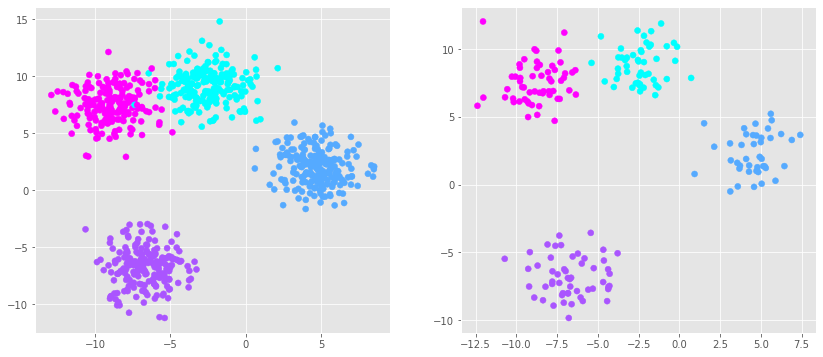

In [ ]:
with plt.style.context('ggplot'):
  fig, axes = plt.subplots(1,2, figsize=(14, 6))
  axes[0].scatter(X_train[:,0],X_train[:,1], cmap=plt.cm.cool, c=y_train)
  axes[1].scatter(X_test[:,0],X_test[:,1], cmap=plt.cm.cool, c=y_test)

In [ ]:
class BlobModel(torch.nn.Module):
  def __init__(self, in_features, out_features, hidden_units=8):
    super().__init__()

    self.linear_layer_stack = torch.nn.Sequential(
        torch.nn.Linear(in_features, hidden_units, device="cuda"),
        # torch.nn.ReLU(),
        torch.nn.Linear(hidden_units, hidden_units, device="cuda"),
        # torch.nn.ReLU(),
        torch.nn.Linear(hidden_units, out_features, device="cuda"),
    )
  def forward(self, x:torch.Tensor) -> torch.Tensor:
    return self.linear_layer_stack(x)


In [ ]:
model2 = BlobModel(2,4)
model2.state_dict()

OrderedDict([('linear_layer_stack.0.weight', tensor([[ 0.5853, -0.1876],
                      [-0.1573, -0.1466],
                      [-0.3428, -0.0958],
                      [ 0.4204,  0.4401],
                      [-0.1219, -0.2463],
                      [-0.3217,  0.1384],
                      [-0.6959, -0.4802],
                      [ 0.3776, -0.1935]], device='cuda:0')),
             ('linear_layer_stack.0.bias',
              tensor([-0.4789, -0.1575, -0.4596, -0.1628, -0.7067,  0.2124, -0.0954, -0.5152],
                     device='cuda:0')),
             ('linear_layer_stack.1.weight',
              tensor([[-0.2134, -0.3450,  0.1967, -0.0694,  0.2828, -0.1374,  0.0061, -0.0033],
                      [-0.0428, -0.0488, -0.2514, -0.3502,  0.2498,  0.0779,  0.3174,  0.2487],
                      [-0.2777, -0.0008,  0.3109,  0.2321, -0.1529,  0.2725, -0.2123,  0.1720],
                      [-0.3144,  0.1269, -0.0746,  0.2174, -0.2512, -0.0404,  0.0058, -0.3132],
      

In [ ]:
lossFn = torch.nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(params=model2.parameters(), lr=0.01)

epochs = 300

for epoch in range(epochs):
  model2.train()

  y_logits = model2(X_train.to(device))
  y_pred_prob = torch.softmax(y_logits, dim=1)
  y_pred = torch.argmax(y_pred_prob, dim=1)
  acc = accuracy_score(y_train, y_pred.cpu())

  loss = lossFn(y_logits, y_train.to(device).type(torch.long))

  optimizer.zero_grad()
  loss.backward()
  optimizer.step()

  model2.eval()
  with torch.inference_mode():
    y_test_logits = model2(X_test.to(device))
    y_test_pred = torch.softmax(y_test_logits, dim=1).argmax(dim=1)
    acc_test = accuracy_score(y_test, y_test_pred.cpu())

    loss_test = lossFn(y_test_logits, y_test.to(device).type(torch.long))
    if epoch % 10 == 0:
      print(f"Epoch{epoch}: loss-{loss:.5f} acc-{acc*100:.2f}% | loss_test {loss_test:.5f} acc_test-{acc_test*100:.2f}%")



Epoch0: loss-1.89479 acc-50.25% | loss_test 1.49330 acc_test-49.00%
Epoch10: loss-0.34457 acc-98.38% | loss_test 0.31286 acc_test-100.00%
Epoch20: loss-0.13204 acc-99.00% | loss_test 0.11732 acc_test-99.50%
Epoch30: loss-0.07009 acc-99.38% | loss_test 0.06155 acc_test-100.00%
Epoch40: loss-0.04712 acc-99.38% | loss_test 0.03988 acc_test-100.00%
Epoch50: loss-0.03686 acc-99.50% | loss_test 0.02825 acc_test-100.00%
Epoch60: loss-0.03171 acc-99.50% | loss_test 0.02296 acc_test-100.00%
Epoch70: loss-0.02878 acc-99.50% | loss_test 0.01975 acc_test-100.00%
Epoch80: loss-0.02688 acc-99.50% | loss_test 0.01743 acc_test-100.00%
Epoch90: loss-0.02552 acc-99.50% | loss_test 0.01590 acc_test-100.00%
Epoch100: loss-0.02448 acc-99.50% | loss_test 0.01464 acc_test-100.00%
Epoch110: loss-0.02366 acc-99.50% | loss_test 0.01362 acc_test-100.00%
Epoch120: loss-0.02298 acc-99.50% | loss_test 0.01280 acc_test-100.00%
Epoch130: loss-0.02242 acc-99.50% | loss_test 0.01208 acc_test-100.00%
Epoch140: loss-0.02

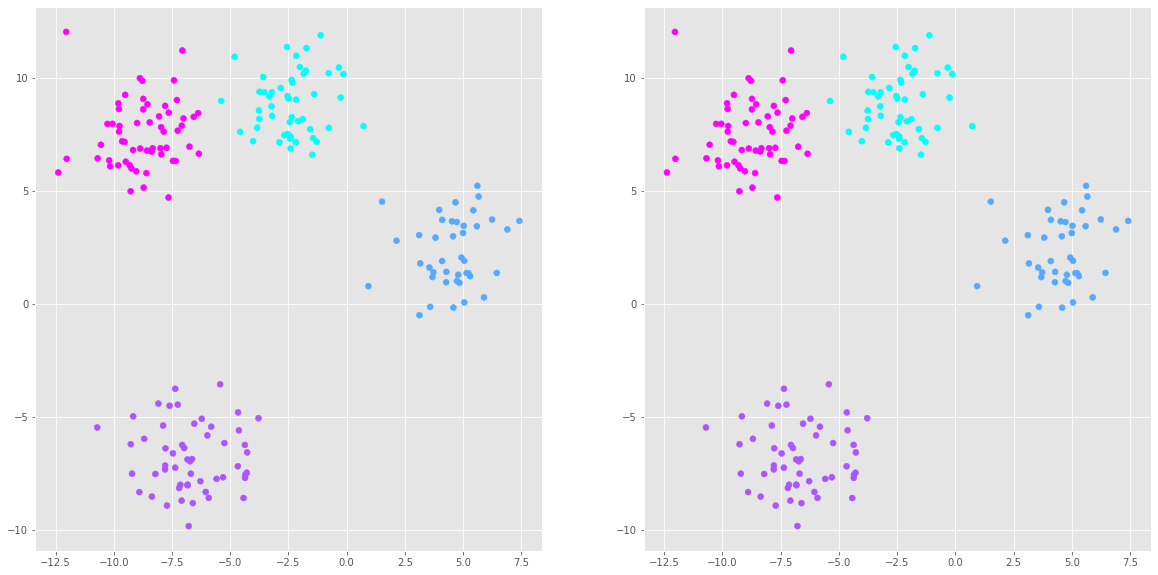

In [ ]:
model2.eval()
with torch.inference_mode():
  y_test_logits = model2(X_test.to(device))
  y_test_pred = torch.softmax(y_test_logits, dim=1).argmax(dim=1)

with plt.style.context('ggplot'):
  fig, axes = plt.subplots(1,2,figsize=(20,10))
  axes[0].scatter(X_test[:,0], X_test[:,1], c=y_test, cmap=plt.cm.cool)
  axes[1].scatter(X_test[:,0], X_test[:,1], c=y_test_pred.cpu(), cmap=plt.cm.cool)